In [ ]:
import tensorflow as tf
import numpy as np
import gym
import gym.spaces
import datetime as dt
import matplotlib.pyplot as plt

In [ ]:
env = gym.make("LunarLander-v2")

In [ ]:
class Agent:
    
    def __init__(self, name, input_layer, hsize, action_space_n, random_init=True):
        self.name = name
        self.hsize = hsize
        self.action_space_n = action_space_n
        with tf.variable_scope(name,reuse=False):
            self.input = input_layer
            self.h1 = tf.layers.dense(input_layer,hsize[0],activation=tf.nn.leaky_relu)
            self.h2 = tf.layers.dense(self.h1,hsize[1],activation=tf.nn.leaky_relu)
            self.out = tf.layers.dense(self.h2, action_space_n, activation=tf.nn.softmax)
            
    def zero(self):
        tr_vars = self.train_vars()
        for var in tr_vars:
            sess.run(tf.assign(var, tf.zeros_like(var)))
        
    def from_population(self, agents, weights):
        self.zero()
        weight = 1. / len(agents)
        train_vars = self.train_vars()
        for i in range(len(agents)):
        # for i in range(1):
            current_agent_vars = agents[i].train_vars()
            for j in range(len(current_agent_vars)):
            # for j in range(1):
                # print("train_vars[j]:\n", sess.run(train_vars[j]))
                # print("weights[i]:\n", weights[i])
                # print("current_agent_vars[j]:\n", sess.run(current_agent_vars[j]))
                # print("train_vars[j] + weights[i] * current_agent_vars[j]:\n", sess.run(train_vars[j] + weights[i] * current_agent_vars[j]))
                sess.run(tf.assign(train_vars[j], train_vars[j] + weights[i] * current_agent_vars[j]))
                # print("train_vars[j]:\n", sess.run(train_vars[j]))
        # print("from_population: ", sess.run(self.train_vars()[0])[0][0:5])
        return self
                
    def from_agent(self, agent, noise_dist = None):
        self_train_vars = self.train_vars()
        agent_train_vars = agent.train_vars()
        for i in range(len(self_train_vars)):
            if noise_dist is None:
                sess.run(tf.assign(self_train_vars[i], agent_train_vars[i]))
            else:
                sess.run(tf.assign(self_train_vars[i], agent_train_vars[i] + noise_dist.sample(agent_train_vars[i].shape)))
        return self
                
    def compute(self, observation):
        obs_np = np.array(observation).reshape((1, 8))
        return sess.run(self.out, feed_dict= {X : obs_np})
    
    def train_vars(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.name)
    
    def update(self, agent):
        pass

In [ ]:
num_agents = 10
num_games_per_agent = 50
max_steps = 300
num_generations = 3
hsizes = [24, 24]
alpha = 0.03
sigma = 0.03

In [ ]:
X = tf.placeholder(tf.float32,[None, env.observation_space.shape[0]])

In [ ]:
normal_dist = tf.distributions.Normal(loc=0., scale=sigma)

In [ ]:
smith = Agent(name="Agent_Smith", input_layer=X, hsize=hsizes, action_space_n=env.action_space.n)
print(smith.train_vars())
agents = []
for i in range(num_agents):
    # agents.append(agent("agent/%d" % (i,), input_layer=X, hsize=hsizes, reuse=False, action_space_n=env.action_space.n))
    agents.append(Agent("agent/%d" % (i,), input_layer=X, hsize=hsizes, action_space_n=env.action_space.n))

In [ ]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

In [ ]:
#for i in range(num_agents):
#    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "agent/%d" % (i,))
#    print(sess.run(train_vars))
#    print("======================")

In [ ]:
def play(env, agent, num_games, max_steps, render):
    rewards = np.zeros([num_games])
    actions = [_ for _ in range(env.action_space.n)]
    for g in range(num_games):
        obs = env.reset()
        #print(obs)
        reward_accum = 0
        for i in range(max_steps):
            # obs_np = np.array(obs).reshape((1, 8))
            # action_probabilities = sess.run(agent, feed_dict= {X : obs_np})
            action_probabilities = agent.compute(obs)[0]
            
            #obs, r, done, info = env.step(env.action_space.sample())
            action = np.random.choice(a=actions, p=action_probabilities)
            obs, r, done, info = env.step(action)
            if render == True:
                env.render()
            reward_accum += r
            if done == True:
                break
        rewards[g] = reward_accum
    return rewards.sum()

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [ ]:
generation = 1
max_rewards = []
avg_rewards = []
training_history = {}

In [91]:
start = dt.datetime.now()
print("training started: " + str(start))
# for generation in range(num_generations):
stop_requested = False
while(stop_requested == False):
    rewards_np = np.zeros([num_agents])
    for i in range(num_agents):
        rewards_np[i] = play(env=env, agent=agents[i], num_games=num_games_per_agent, max_steps=max_steps, render=False)
    print(generation, rewards_np.max(), rewards_np.mean())
    max_rewards.append(rewards_np.max())
    avg_rewards.append(rewards_np.mean())
    ind = np.argmax(rewards_np)
    #weights = np.zeros((num_agents, ))
    # weights[ind] = 1.
    # smith.from_population(agents=agents, weights = weights  )
    smith.from_population(agents=(agents[ind],), weights = (1, )  )
    for i in range(num_agents):
        # if i == 0:
        #    print(sess.run(agents[i].train_vars()[0])[0][0:5])
        agents[i].from_agent(agent=smith, noise_dist=normal_dist)
        
    with open("/home/martin/1.ctl") as f:
        cmd = f.readline()
        if cmd.find("RUN") < 0:
            stop_requested = True
    
    if generation % 50 == 0:
        training_history[generation] = Agent(name="Generation_%d" % generation, \
                                             input_layer=X, \
                                             hsize=hsizes, \
                                             action_space_n=env.action_space.n).from_agent(smith)
        
    generation += 1

end = dt.datetime.now()
print("training ended: " + str(end))
print("total training time: " + str(end - start))
print("average generation training time: ", str((end - start).total_seconds() / len(max_rewards)) )

training started: 2018-09-15 12:36:17.990747
228 3064.49929616376 2423.052811110558
229 3080.8422090666245 1997.2990636202583
230 2685.9978816625485 2189.719147607794
training ended: 2018-09-15 13:06:56.030325
total training time: 0:30:38.039578
average generation training time:  7.991476426086956


In [109]:
np.save('/home/martin/reinforcement_learning_runs/LunarLander-v2/1/max_rewards', max_rewards)
np.save('/home/martin/reinforcement_learning_runs/LunarLander-v2/1/avg_rewards', avg_rewards)

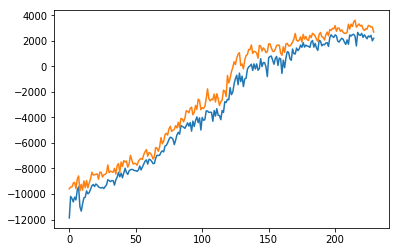

In [110]:
plt.plot(range(len(avg_rewards)), avg_rewards)
plt.plot(range(len(max_rewards)), max_rewards)
plt.show()

accum reward:  -42.539042893469556


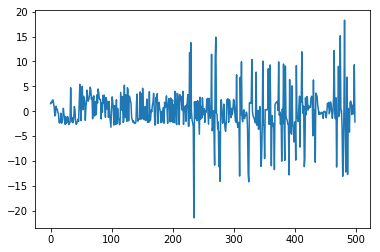

In [108]:
obs = env.reset()
actions = [_ for _ in range(env.action_space.n)]
rewards = []

for i in range(500):
    action_probabilities = smith.compute(obs)[0]
            
    # obs, r, done, info = env.step(env.action_space.sample())
    # action = np.random.choice(a=actions, p=action_probabilities)
    # o, r, done, info = env.step(env.action_space.sample())
    
    action = np.random.choice(a=actions, p=action_probabilities)
    obs, r, done, info = env.step(action)
    rewards.append(r)
    env.render()
    #print(obs, r, done, info)
    if done:
        break

print ("accum reward: ", np.array(rewards).sum())
plt.plot(range(len(rewards)), rewards)
plt.show()